# Data source

Data for download: https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

Resources used as reference:
1) Training the image classifier to recognize different species of flowers:
https://www.kaggle.com/dtosidis/flower-classifier-tensorflow
  
2) Loading and preprocessing an image dataset
https://www.tensorflow.org/tutorials/load_data/images

3) Data augmentation
https://www.tensorflow.org/tutorials/images/data_augmentation

4) Image classification
https://www.tensorflow.org/tutorials/images/classification


In [3]:
# Dependencies
import matplotlib.pyplot as plt
%matplotlib inline



import os
import numpy as np
import tensorflow as tf

import PIL
import PIL.Image

import pathlib

os.environ['KMP_DUPLICATE_LIB_OK']='True'

from tensorflow import keras
from tensorflow.keras.preprocessing import image
import tensorflow_hub as hub

from tensorflow.keras.applications.vgg19 import (
    VGG19, 
    preprocess_input, 
    decode_predictions
)

In [4]:
!pwd

/c/ShankersDocs/EDUCATION/RICE_Bootcamp_DataAnalytics/FinalProject_Img_Recognition_Flowers/Final_RICEproject_ImageRecognition_flowers


### Total images in the dataset

In [5]:
data_dir = 'flower_photos'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
# print(image_count)

## Image Classification
https://www.tensorflow.org/tutorials/images/classification?hl=zh-tw

In [6]:

batch_size = 32
img_height = 224
img_width = 224

## Generating datasets
https://keras.io/examples/vision/image_classification_from_scratch/

### Generating a training dataset

In [7]:
# When the subset below is defined as "training" the 0.2 validation split takes 80% of the data as the training set

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'flower_photos',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


### Generating a validation dataset

In [8]:
# When the subset below is defined as "validation" the 0.1 validation split takes 10% of the data as the validation set

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'flower_photos',
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 367 files for validation.


### Generating a test dataset

In [9]:
# When the subset below is defined as "validation" the 0.1 validation split takes 10% of the data as the test set

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'flower_photos',
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 367 files for validation.


### Class names

In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Rescaling the data
https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling


In [11]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

### Normalizing the data (trainign and validation datasets)

In [12]:
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds =  val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


### Autotune is done to cache data and make processing and resource mgmt more effieicient

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalized_train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalized_val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# num_classes = 5
num_classes = len(class_names)
num_classes

5

In [16]:
def plot_history(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Model 1 (Sequential Model)
https://www.tensorflow.org/guide/keras/sequential_model

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [39]:
history = model.fit(
    train_ds,
    validation_data = val_ds, 
    epochs=10
)


Epoch 1/10
92/92 [==============================] - 6s 70ms/step - loss: 1.6579 - accuracy: 0.2268 - val_loss: 2.4114 - val_accuracy: 0.2071
Epoch 2/10
92/92 [==============================] - 6s 69ms/step - loss: 1.6016 - accuracy: 0.2497 - val_loss: 2.4061 - val_accuracy: 0.2371
Epoch 3/10
92/92 [==============================] - 6s 70ms/step - loss: 1.5918 - accuracy: 0.2537 - val_loss: 2.4051 - val_accuracy: 0.2371
Epoch 4/10
92/92 [==============================] - 6s 69ms/step - loss: 1.5903 - accuracy: 0.2537 - val_loss: 2.4042 - val_accuracy: 0.2371
Epoch 5/10
92/92 [==============================] - 6s 69ms/step - loss: 1.5893 - accuracy: 0.2537 - val_loss: 2.4034 - val_accuracy: 0.2371
Epoch 6/10
92/92 [==============================] - 6s 70ms/step - loss: 1.5884 - accuracy: 0.2537 - val_loss: 2.4028 - val_accuracy: 0.2371
Epoch 7/10
92/92 [==============================] - 6s 70ms/step - loss: 1.5877 - accuracy: 0.2537 - val_loss: 2.4022 - val_accuracy: 0.2371
Epoch 8/10
92

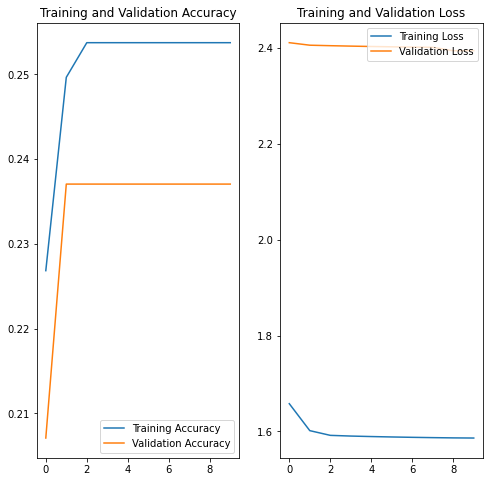

In [40]:
plot_history(history, 10)

## Model 1 (Sequential Model) Epoch sensitivity

In [24]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [25]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [30]:
model.fit(
    train_ds,
    validation_data = val_ds, 
    epochs=6
)

Epoch 1/6
92/92 [==============================] - 6s 68ms/step - loss: 3109.6846 - accuracy: 0.3198 - val_loss: 2002.3905 - val_accuracy: 0.3324
Epoch 2/6
92/92 [==============================] - 6s 64ms/step - loss: 1059.0967 - accuracy: 0.3740 - val_loss: 1328.4467 - val_accuracy: 0.2425
Epoch 3/6
92/92 [==============================] - 6s 65ms/step - loss: 676.3892 - accuracy: 0.4217 - val_loss: 1104.6982 - val_accuracy: 0.3324
Epoch 4/6
92/92 [==============================] - 6s 67ms/step - loss: 480.6086 - accuracy: 0.4561 - val_loss: 832.1366 - val_accuracy: 0.3569
Epoch 5/6
92/92 [==============================] - 6s 66ms/step - loss: 406.3172 - accuracy: 0.4935 - val_loss: 830.6475 - val_accuracy: 0.3706
Epoch 6/6
92/92 [==============================] - 6s 66ms/step - loss: 464.5512 - accuracy: 0.4816 - val_loss: 1717.7488 - val_accuracy: 0.2834


## Model 1a (Sequential Model) With Normalized data

In [41]:
model_1a = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [42]:
model_1a.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [43]:
history1a = model_1a.fit(
    normalized_train_ds,
    validation_data = normalized_val_ds, 
    epochs=10
)

Epoch 1/10
92/92 [==============================] - 7s 71ms/step - loss: 15.9169 - accuracy: 0.3198 - val_loss: 3.7873 - val_accuracy: 0.2016
Epoch 2/10
92/92 [==============================] - 6s 70ms/step - loss: 2.0708 - accuracy: 0.3913 - val_loss: 3.0436 - val_accuracy: 0.3869
Epoch 3/10
92/92 [==============================] - 6s 70ms/step - loss: 1.7896 - accuracy: 0.4574 - val_loss: 2.7329 - val_accuracy: 0.3025
Epoch 4/10
92/92 [==============================] - 6s 70ms/step - loss: 1.4046 - accuracy: 0.5041 - val_loss: 3.2498 - val_accuracy: 0.2943
Epoch 5/10
92/92 [==============================] - 6s 70ms/step - loss: 1.4433 - accuracy: 0.5143 - val_loss: 2.5417 - val_accuracy: 0.3406
Epoch 6/10
92/92 [==============================] - 6s 70ms/step - loss: 1.8300 - accuracy: 0.4237 - val_loss: 3.4987 - val_accuracy: 0.2398
Epoch 7/10
92/92 [==============================] - 7s 71ms/step - loss: 1.6175 - accuracy: 0.3614 - val_loss: 1.4373 - val_accuracy: 0.3951
Epoch 8/10
9

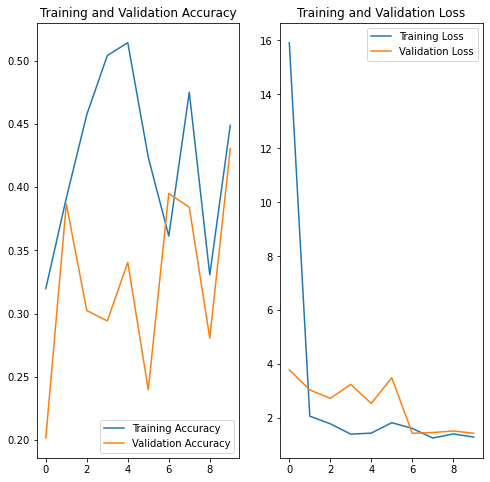

In [44]:
plot_history(history1a, 10)

## Model 2 

In [14]:
model_2 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model_2.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [16]:
model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=1
)

92/92 [==============================] - 80s 872ms/step - loss: 1.2945 - accuracy: 0.4377 - val_loss: 1.1570 - val_accuracy: 0.5259


In [17]:
!pwd

/c/ShankersDocs/EDUCATION/RICE_Bootcamp_DataAnalytics/FinalProject_Img_Recognition_Flowers/Final_RICEproject_ImageRecognition_flowers


In [18]:
import sys
print(sys.executable)a

C:\ProgramData\Anaconda3\envs\Mlearning\python.exe


In [19]:
!conda info


     active environment : Mlearning
    active env location : C:\ProgramData\Anaconda3\envs\Mlearning
            shell level : 2
       user config file : C:\Users\nairs\.condarc
 populated config files : C:\Users\nairs\.condarc
          conda version : 4.8.3
    conda-build version : 3.18.11
         python version : 3.7.6.final.0
       virtual packages : __cuda=10.2
       base environment : C:\ProgramData\Anaconda3  (writable)
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.anaconda.com/pkgs/msys2/noarch
          package cache : C:\ProgramData\Anaconda3\pkgs
                          C:\Users\nairs\.conda\pkgs
                          C:\Users\nairs\Ap

In [23]:
model_2.save('C:/Users/nairs/Desktop/model_2')

INFO:tensorflow:Assets written to: C:/Users/nairs/Desktop/model_2\assets


## Model 3 - TRAINED MODEL

In [45]:
module_selection = ("mobilenet_v2_100_224", 224) 
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)

In [46]:
MODULE_HANDLE

'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4'

In [47]:
pixels

224

In [48]:
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [49]:
do_fine_tuning = False 

In [50]:
IMAGE_SIZE

(224, 224)

In [51]:
print("Building model with", MODULE_HANDLE)
model3 = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4


In [52]:
model3.build((None,)+IMAGE_SIZE+(3,))

In [53]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [54]:
model3.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [34]:
# model3.fit(
#     normalized_train_ds,
#     validation_data = normalized_val_ds, 
#     epochs=6
# )

In [ ]:
# epochs = 2

In [55]:
history3 = model3.fit(
    normalized_train_ds,
    validation_data = normalized_val_ds, 
    epochs=10
)

Epoch 1/10
92/92 [==============================] - 43s 463ms/step - loss: 0.6438 - accuracy: 0.7650 - val_loss: 0.3087 - val_accuracy: 0.9046
Epoch 2/10
92/92 [==============================] - 47s 510ms/step - loss: 0.3426 - accuracy: 0.8774 - val_loss: 0.2694 - val_accuracy: 0.9183
Epoch 3/10
92/92 [==============================] - 48s 520ms/step - loss: 0.2943 - accuracy: 0.8917 - val_loss: 0.2713 - val_accuracy: 0.9155
Epoch 4/10
92/92 [==============================] - 50s 546ms/step - loss: 0.2600 - accuracy: 0.9104 - val_loss: 0.2444 - val_accuracy: 0.9210
Epoch 5/10
92/92 [==============================] - 55s 600ms/step - loss: 0.2246 - accuracy: 0.9278 - val_loss: 0.2401 - val_accuracy: 0.9210
Epoch 6/10
92/92 [==============================] - 66s 717ms/step - loss: 0.2159 - accuracy: 0.9254 - val_loss: 0.2342 - val_accuracy: 0.9264
Epoch 7/10
92/92 [==============================] - 60s 655ms/step - loss: 0.1955 - accuracy: 0.9360 - val_loss: 0.2352 - val_accuracy: 0.9155

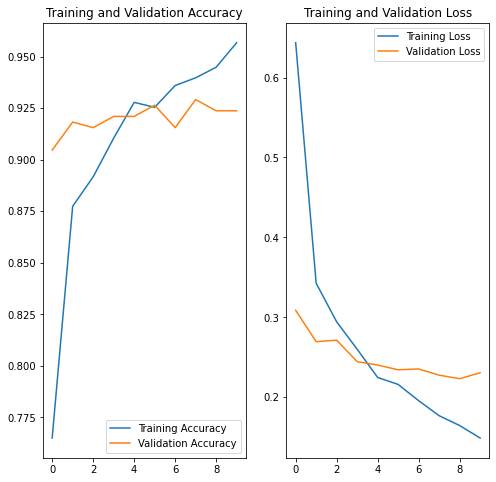

In [56]:
plot_history(history3, 10)

In [36]:
# # TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(2)

# plt.figure(figsize=(6, 6))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()
# # plt.savefig('ML_output_plots/epoch_10.png')

In [ ]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = epochs

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
model3.fit(
    normalized_train_ds,
    validation_data = normalized_val_ds, 
    epochs=3
)

Epoch 1/12
92/92 [==============================] - 55s 602ms/step - loss: 0.2840 - accuracy: 0.8985 - val_loss: 0.2562 - val_accuracy: 0.9155
Epoch 2/12
92/92 [==============================] - 54s 582ms/step - loss: 0.2544 - accuracy: 0.9128 - val_loss: 0.2415 - val_accuracy: 0.9074
Epoch 3/12
92/92 [==============================] - 53s 581ms/step - loss: 0.2269 - accuracy: 0.9223 - val_loss: 0.2440 - val_accuracy: 0.9237
Epoch 4/12
92/92 [==============================] - 60s 647ms/step - loss: 0.1989 - accuracy: 0.9360 - val_loss: 0.2396 - val_accuracy: 0.9237
Epoch 5/12
92/92 [==============================] - 56s 604ms/step - loss: 0.1983 - accuracy: 0.9292 - val_loss: 0.2330 - val_accuracy: 0.9237
Epoch 6/12
92/92 [==============================] - 55s 597ms/step - loss: 0.1833 - accuracy: 0.9421 - val_loss: 0.2268 - val_accuracy: 0.9237
Epoch 7/12
92/92 [==============================] - 55s 594ms/step - loss: 0.1733 - accuracy: 0.9428 - val_loss: 0.2265 - val_accuracy: 0.9346

In [24]:
model3.fit(
    normalized_train_ds,
    validation_data = normalized_val_ds, 
    epochs=18
)

Epoch 1/18
92/92 [==============================] - 86s 934ms/step - loss: 0.6653 - accuracy: 0.7565 - val_loss: 0.3333 - val_accuracy: 0.8856
Epoch 2/18
92/92 [==============================] - 81s 883ms/step - loss: 0.3439 - accuracy: 0.8815 - val_loss: 0.3096 - val_accuracy: 0.8992
Epoch 3/18
92/92 [==============================] - 81s 885ms/step - loss: 0.2921 - accuracy: 0.8985 - val_loss: 0.2896 - val_accuracy: 0.9019
Epoch 4/18
92/92 [==============================] - 146s 2s/step - loss: 0.2530 - accuracy: 0.9104 - val_loss: 0.2754 - val_accuracy: 0.9128
Epoch 5/18
92/92 [==============================] - 214s 2s/step - loss: 0.2397 - accuracy: 0.9166 - val_loss: 0.2743 - val_accuracy: 0.9155
Epoch 6/18
92/92 [==============================] - 206s 2s/step - loss: 0.2092 - accuracy: 0.9288 - val_loss: 0.2597 - val_accuracy: 0.9292
Epoch 7/18
92/92 [==============================] - 146s 2s/step - loss: 0.1932 - accuracy: 0.9360 - val_loss: 0.2579 - val_accuracy: 0.9292
Epoch 8

In [33]:
model3.save('C:/Users/nairs/Desktop/mobilenet_model_80_20')

INFO:tensorflow:Assets written to: C:/Users/nairs/Desktop/mobilenet_model_80_20\assets


INFO:tensorflow:Assets written to: C:/Users/nairs/Desktop/mobilenet_model_80_20\assets


In [26]:
model3.save_weights("mobilenet_model_80_20.hdf5")